In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
DATA_STORE = Path("data-store")

---

In [5]:
START = 2000
END = 2018

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [8]:
prices.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN


In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [10]:
stocks.head()

,marketcap,ipoyear,sector
ticker,,,
PIH,43090000.0,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,70330000.0,NaN,Finance
FLWS,833390000.0,1999.0,Consumer Services
FCCY,178140000.0,NaN,Finance


Remove stocks duplicates and align index names for later joining.

In [11]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [12]:
shared = prices.columns.intersection(stocks.index)

In [13]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [14]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [15]:
assert prices.shape[1] == stocks.shape[0]

---

In [16]:
monthly_prices = prices.resample("M").last()

In [17]:
monthly_prices.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,45.157511,NaN,NaN,NaN,4.766882,NaN,1.211345,NaN,3.333330,NaN,...,NaN,4.176075,NaN,46.927728,NaN,30.88,NaN,NaN,NaN,NaN
2000-02-29,70.884807,NaN,NaN,NaN,4.941969,NaN,1.296459,NaN,3.682567,NaN,...,NaN,4.176075,NaN,42.110354,NaN,53.78,NaN,NaN,NaN,NaN
2000-03-31,70.953031,NaN,NaN,NaN,4.834658,NaN,1.334456,NaN,4.363369,NaN,...,NaN,3.712067,NaN,33.039089,NaN,72.81,NaN,NaN,NaN,NaN
2000-04-30,60.466992,NaN,NaN,NaN,4.360229,NaN,1.595875,NaN,3.985860,NaN,...,NaN,4.408079,NaN,32.935916,NaN,36.94,NaN,NaN,NaN,NaN
2000-05-31,50.233382,NaN,NaN,NaN,4.312221,NaN,1.852735,NaN,2.698793,NaN,...,NaN,4.118538,NaN,36.732135,NaN,28.00,NaN,NaN,NaN,NaN


In [18]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: ME
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [19]:
monthly_prices.pct_change(3).stack()

date        ticker
2000-04-30  A         0.339024
            AAN      -0.085308
            AAON      0.317440
            AAPL      0.195759
            ABAX     -0.123077
                        ...   
2018-03-31  ZIXI      0.002283
            ZNGA     -0.075000
            ZOES     -0.110048
            ZTS       0.136313
            ZUMZ      0.133253
Length: 421165, dtype: float64

In [20]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399525 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   399525 non-null  float64
 1   return_2m   399525 non-null  float64
 2   return_3m   399525 non-null  float64
 3   return_6m   399525 non-null  float64
 4   return_9m   399525 non-null  float64
 5   return_12m  399525 non-null  float64
dtypes: float64(6)
memory usage: 19.9+ MB


In [21]:
data.head()

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2001-01-31,-0.003653,0.022360,0.056104,0.049811,-0.052500,-0.015988
AAN,2001-01-31,0.116071,0.008439,-0.015687,-0.009856,-0.002912,-0.009572
AAON,2001-01-31,0.300170,0.034296,0.028670,-0.006238,0.010159,0.031027
AAPL,2001-01-31,0.430943,0.144685,0.033941,-0.132736,-0.110514,-0.070339
ABAX,2001-01-31,-0.073762,-0.042573,-0.044914,-0.003738,-0.028353,-0.031993


Drop stocks with less than 10 yrs of returns

In [22]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [23]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


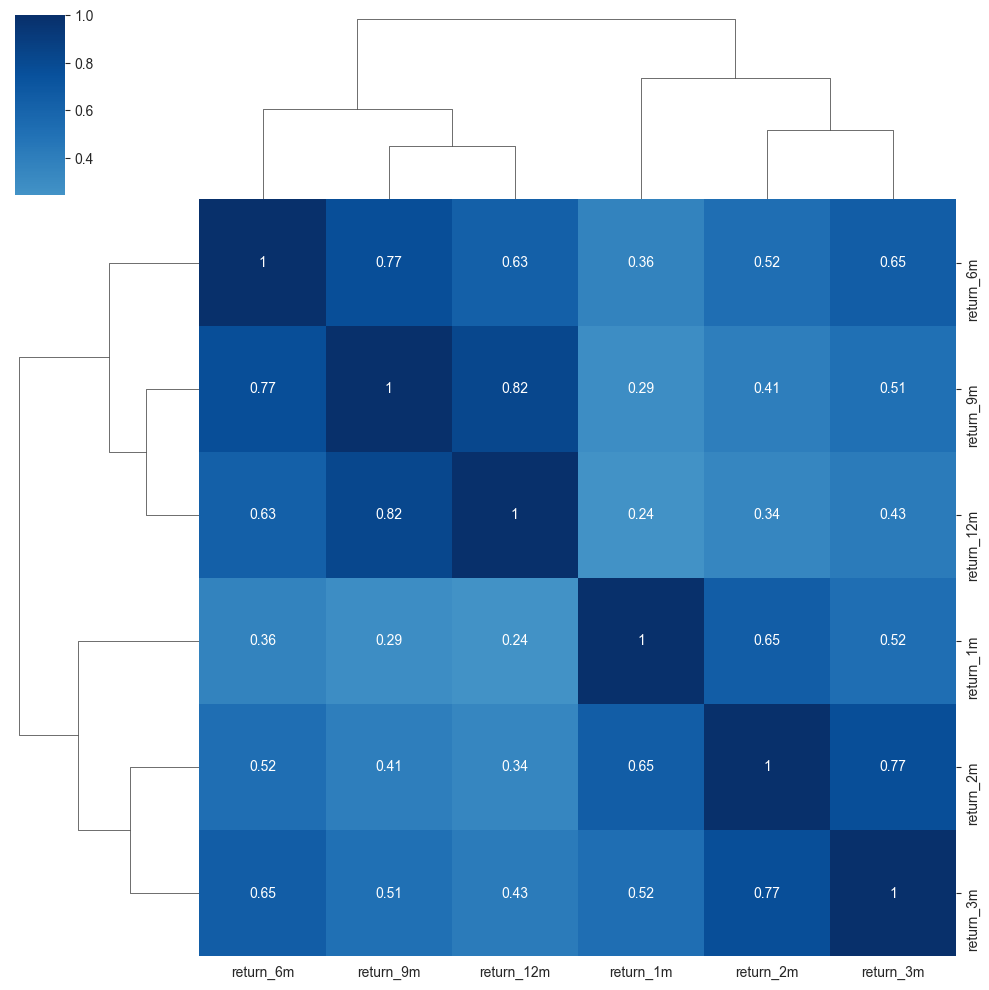

In [24]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')

In [25]:
data.index.get_level_values('ticker').nunique()

1838

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

In [26]:
# factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2000-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  300 non-null    float64
 1   SMB     300 non-null    float64
 2   HML     300 non-null    float64
 3   RMW     300 non-null    float64
 4   CMA     300 non-null    float64
dtypes: float64(5)
memory usage: 14.1 KB


In [27]:
factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0442,-0.0188,-0.0629,0.0472
2000-02-29,0.0245,0.1828,-0.0959,-0.1865,-0.0048
2000-03-31,0.0520,-0.1532,0.0813,0.1179,-0.0159
2000-04-30,-0.0640,-0.0501,0.0726,0.0766,0.0565
2000-05-31,-0.0442,-0.0381,0.0475,0.0413,0.0137
